# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Explaining-Decision-Trees-and-Random-Forests" data-toc-modified-id="Explaining-Decision-Trees-and-Random-Forests-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Explaining Decision Trees and Random Forests</a></div><div class="lev1 toc-item"><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import Libraries</a></div><div class="lev1 toc-item"><a href="#How-Do-Decision-Trees-Work?" data-toc-modified-id="How-Do-Decision-Trees-Work?-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>How Do Decision Trees Work?</a></div><div class="lev1 toc-item"><a href="#Load-Data" data-toc-modified-id="Load-Data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load Data</a></div><div class="lev1 toc-item"><a href="#Build-Model" data-toc-modified-id="Build-Model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Build Model</a></div><div class="lev2 toc-item"><a href="#Create-Feature-Contribution" data-toc-modified-id="Create-Feature-Contribution-51"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Create Feature Contribution</a></div><div class="lev1 toc-item"><a href="#Visualizing-Decision-Trees" data-toc-modified-id="Visualizing-Decision-Trees-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Visualizing Decision Trees</a></div><div class="lev1 toc-item"><a href="#Contributions" data-toc-modified-id="Contributions-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Contributions</a></div><div class="lev2 toc-item"><a href="#Regression-Contributions" data-toc-modified-id="Regression-Contributions-71"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Regression Contributions</a></div><div class="lev2 toc-item"><a href="#Decision-Tree-Features-vs.-Contributions" data-toc-modified-id="Decision-Tree-Features-vs.-Contributions-72"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Decision Tree Features vs. Contributions</a></div><div class="lev2 toc-item"><a href="#Extending-to-Random-Forests" data-toc-modified-id="Extending-to-Random-Forests-73"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Extending to Random Forests</a></div><div class="lev2 toc-item"><a href="#Multi-class-classification" data-toc-modified-id="Multi-class-classification-74"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>Multi-class classification</a></div>

# Explaining Decision Trees and Random Forests

This notebook shows examples of how the `treeinterpreter` (<a href='https://github.com/andosa/treeinterpreter'>https://github.com/andosa/treeinterpreter</a>) library works and provides some insightful plots to gain a deeper understanding of what a decision tree or random forest is doing.

I have created a set of useful plotting functions in the file `tree_interp_functions.py`.

# Import Libraries

In [1]:
from __future__ import division

from IPython.display import Image, display
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor,\
                         export_graphviz
from treeinterpreter import treeinterpreter as ti
import pydotplus
import collections
from tree_interp_functions import *
from scipy.special import logit, expit
from sklearn.datasets.california_housing import fetch_california_housing
from sklearn.datasets import load_breast_cancer
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [2]:
# Set default matplotlib settings
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.titlesize'] = 26
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 16

# Set seaborn colours
sns.set_style('darkgrid')
sns.set_palette('colorblind')
blue, green, red, purple, yellow, cyan = sns.color_palette('colorblind')

# How Do Decision Trees Work?

# Load Data
We will use the abalone data set as an example. We would like to show how this works for decision tree and random forest regressors as well as classifiers. We use the `rings` variable as our continuous variable and create a binary variable from it to indicate whether `rings > 9`.

In [3]:
cal_housing = fetch_california_housing()
names = cal_housing.feature_names
calHousing = pd.DataFrame(cal_housing.data, columns=names)
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(calHousing,
                                                        cal_housing.target,
                                                        test_size=0.2,
                                                        random_state=1)

Here, we do a simple train/test split of the data.

In [4]:
cancer_data = load_breast_cancer()
names = cancer_data.feature_names
cancerData = pd.DataFrame(cancer_data.data, columns=names)
cancerTarget = pd.DataFrame(cancer_data.target, columns=["target"])
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(cancerData,
                                                        cancer_data.target,
                                                        test_size=0.2,
                                                        random_state=1)

# Build Model
Now, we build simple decision tree and random forest models. We will limit the depth of the decision tree to show how the interpretation works.

In [5]:
rf_bin_clf = RandomForestClassifier(criterion='entropy', 
                                    max_depth=4,
                                    n_estimators=1000, 
                                    random_state=0)
rf_bin_clf.fit(X_train_c, y_train_c)
gbt_bin_clf = GradientBoostingClassifier(max_depth=4, 
                                         n_estimators=500, 
                                         random_state=0)
gbt_bin_clf.fit(X_train_c, y_train_c)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

In [6]:
rf_feature_imp_c = pd.DataFrame(list(zip(X_train_c.columns,  rf_bin_clf.feature_importances_)), columns=["features", "imp"])
gbt_feature_imp_c = pd.DataFrame(list(zip(X_train_c.columns, gbt_bin_clf.feature_importances_)), columns=["features", "imp"])

In [7]:
gbt_feature_imp_c

,features,imp
0,mean radius,0.001080
1,mean texture,0.001107
2,mean perimeter,0.000000
3,mean area,0.000000
4,mean smoothness,0.000654
5,mean compactness,0.000042
6,mean concavity,0.000095
7,mean concave points,0.006600
8,mean symmetry,0.000044
9,mean fractal dimension,0.000058


In [8]:
rf_feature_imp_c

,features,imp
0,mean radius,0.037843
1,mean texture,0.016815
2,mean perimeter,0.052528
3,mean area,0.036705
4,mean smoothness,0.004534
5,mean compactness,0.014918
6,mean concavity,0.055114
7,mean concave points,0.085989
8,mean symmetry,0.002661
9,mean fractal dimension,0.002951


## Create Feature Contribution
We use the `ti.predict` function to get our predictions, biases, and contributions. The contributions matrix is a 3d array which represents the contribution for each example, feature, and class label.

In [9]:
rf_bin_clf_pred, rf_bin_clf_bias, rf_bin_clf_contrib = ti.predict(rf_bin_clf, X_test_c)
gbt_bin_clf_pred, gbt_bin_clf_bias, gbt_bin_clf_contrib = ti.predict(gbt_bin_clf, X_test_c)

In [10]:
compareGBT = list(zip(expit(gbt_bin_clf_pred), expit(gbt_bin_clf_pred)))

In [11]:
gbt_bin_clf_orig_proba = gbt_bin_clf.predict_proba(X_test_c)

In [12]:
sum_gbt = np.zeros(gbt_bin_clf_pred.shape[0])  
isFirst = True 
norm = 0
learning_rate = gbt_bin_clf.learning_rate
print(gbt_bin_clf.n_estimators)
for ii in range(gbt_bin_clf.n_estimators):
    #print(gbt_bin_clf.estimators_[ii][0].predict(X_test)[0])
    if isFirst:
        sum_gbt += (learning_rate * gbt_bin_clf.estimators_[ii][0].predict(X_test_c))
        isFirst = False
        norm += learning_rate
    else:
        sum_gbt += (learning_rate * gbt_bin_clf.estimators_[ii][0].predict(X_test_c))
        norm += learning_rate
#print("Norm: " + str(norm))
#print("Sum: " + str(sum_gbt))
#print("Sum/Norm: " + str(sum_gbt/norm))
#print("Result: " + str(expit(sum_gbt/norm)))
#print("Target: 0.67489087")

500


(-1e-08, 1e-08)

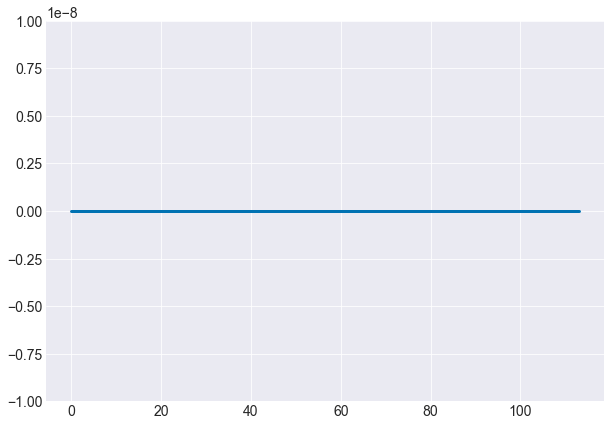

In [13]:
plt.plot(gbt_bin_clf_orig_proba[:, 1]-expit(sum_gbt + logit(y_train_c.mean())))
plt.ylim(-0.00000001, 0.00000001)

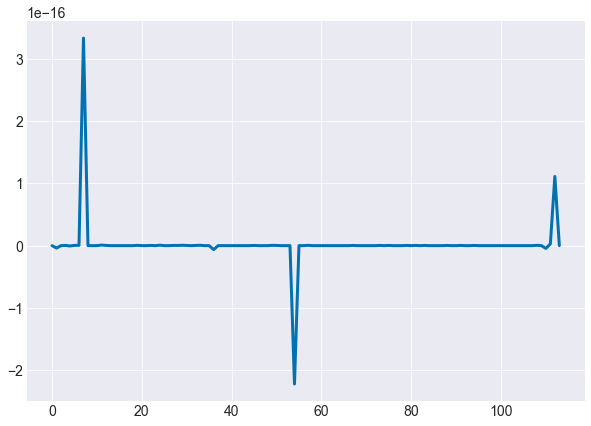

In [14]:
plt.plot(gbt_bin_clf_orig_proba[:, 1] - expit(gbt_bin_clf_pred + logit(y_train_c.mean())))

In [15]:
gbt_bin_clf_orig_proba[:, 1] - (expit(sum_gbt + logit(y_train_c.mean())))

array([ 0.00000000e+00, -3.90312782e-18,  0.00000000e+00,  3.52365706e-19,
       -5.42101086e-19,  4.06575815e-19,  4.33680869e-19,  3.33066907e-16,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  9.21571847e-19,
        3.52365706e-19,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  4.33680869e-19,
        0.00000000e+00,  0.00000000e+00,  3.25260652e-19,  0.00000000e+00,
        7.04731412e-19,  0.00000000e+00,  0.00000000e+00,  3.25260652e-19,
        3.25260652e-19,  5.42101086e-19,  3.25260652e-19,  0.00000000e+00,
        3.25260652e-19,  5.42101086e-19,  0.00000000e+00,  0.00000000e+00,
       -6.39679282e-18,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  3.25260652e-19,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  4.60785923e-19,  3.25260652e-19,  0.00000000e+00,
        0.00000000e+00,  

In [16]:
logit(y_test_c.mean())

0.5389965007326868

In [17]:
logit(y_train_c.mean())

0.5166907432183888

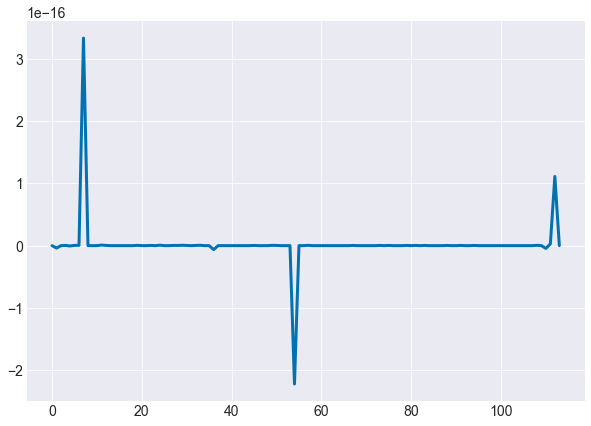

In [18]:
plt.plot(gbt_bin_clf_orig_proba[:, 1]-expit(gbt_bin_clf_pred+ logit(y_train_c.mean())))

# Contributions

## Compare Gradient Boosted Trees to RF and DT

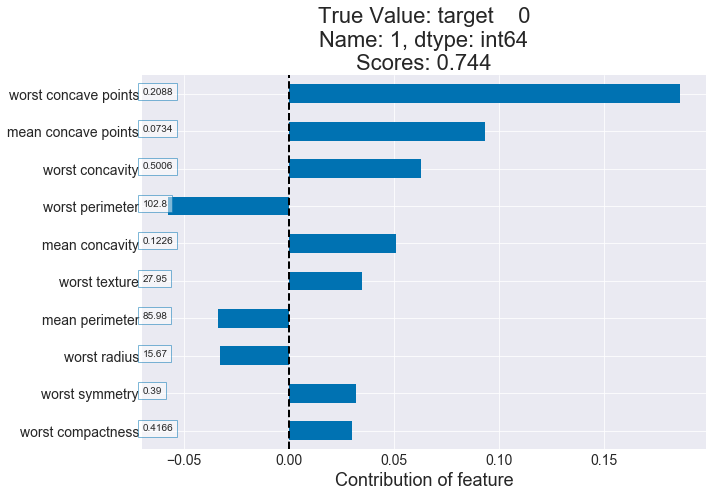

In [19]:
df2, true_label2, pred2 = plot_obs_feature_contrib(rf_bin_clf,
                                                   rf_bin_clf_contrib,
                                                   X_test_c,
                                                   pd.DataFrame(y_test_c,columns=['target']),
                                                   1,
                                                   order_by='contribution',
                                                   num_features=10
                                                  )
plt.tight_layout()
plt.savefig('plots/contribution_plot_rf_class.png')

[1.0, 0.0]


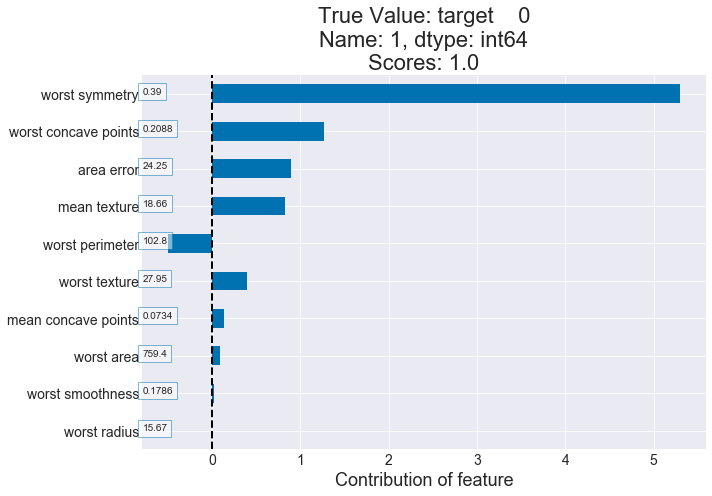

In [20]:
df3, true_label3, pred3 = plot_obs_feature_contrib(gbt_bin_clf,
                                                gbt_bin_clf_contrib,
                                                X_test_c,
                                                pd.DataFrame(y_test_c,columns=['target']),
                                                1,
                                                order_by='contribution',
                                                num_features=10,
                                                   neg=True
                                    )
plt.tight_layout()
plt.savefig('plots/contribution_plot_gbt_class.png')

[1.0, 0.0]


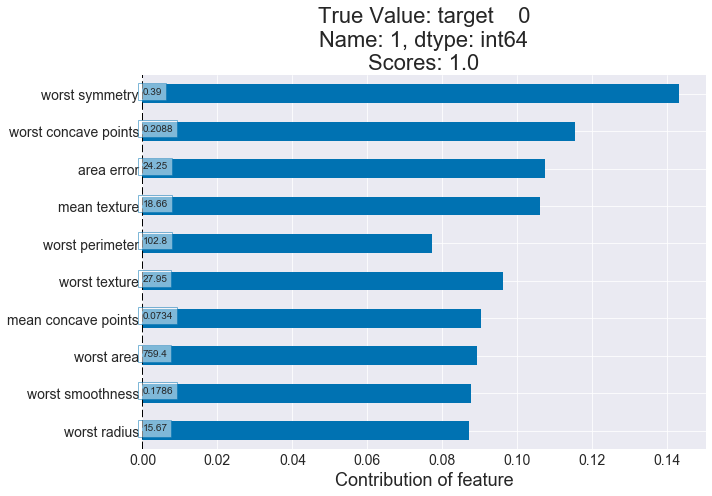

In [24]:
df3, true_label3, pred3 = plot_obs_feature_contrib(gbt_bin_clf,
                                                gbt_bin_clf_contrib,
                                                X_test_c,
                                                pd.DataFrame(y_test_c,columns=['target']),
                                                1,
                                                order_by='contribution',
                                                num_features=10,
                                                prob=True
                                    )
plt.tight_layout()
plt.savefig('plots/contribution_plot_gbt_class.png')

In [22]:
expit(5+ 1.1)-expit(5)

0.004455002403008335

In [23]:
expit(5 + 1.1 + 1) - expit(6.1)

0.0014134238348780803

In [ ]:
expit(1) # contrib

In [ ]:
expit(1.1)-expit(1)

In [ ]:
expit(5)-expit(2.1)

In [ ]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


In [ ]:
softmax(gbt_bin_clf_contrib[1])

In [ ]:
df3, true_label3, pred3 = plot_obs_feature_contrib(gbt_bin_clf,
                                                gbt_bin_clf_contrib,
                                                X_test_c,
                                                pd.DataFrame(y_test_c,columns=['target']),
                                                1,
                                                order_by='contribution',
                                                num_features=100                                                                
                                    )
plt.tight_layout()
plt.savefig('plots/contribution_plot_gbt_class.png')

## Regression Contributions

In [ ]:
idxTest = 1
calcProba = 1.0 - expit((gbt_bin_clf_pred[idxTest] + logit(y_train_c.mean())))

print("         y_mean: " + str(y_train_c.mean()))
print("  logit(y_mean): " + str(logit(y_train_c.mean())))
print("          pred2: " + str(gbt_bin_clf_pred[idxTest]))
print("          origP: " + str(gbt_bin_clf_orig_proba[idxTest][0]))
print("         calcP : " + str(calcProba))
print("logit(calcProb): " + str(logit(calcProba)))
#print(gbt_bin_clf_contrib[0])
print("    sum contrib: " + str(gbt_bin_clf_contrib[idxTest].sum()))
print("           bias: " + str(gbt_bin_clf_bias[idxTest]))
print("sum contrib + b: " + str(gbt_bin_clf_contrib[idxTest].sum() + gbt_bin_clf_bias[0]))
print("          Label: " + str(y_test_c[idxTest]))

print("sum(contrib) + b = prediction")
print("expit( prediction + logit(y_mean)) = proba")

In [ ]:
gbt_bin_clf_contrib[1]

In [ ]:
gbt_bin_clf_bias[0]

In [ ]:
gbt_bin_clf_bias[0]

In [ ]:
foo = gbt_bin_clf_contrib.sum(axis=1)
print(foo.shape)
print(foo)
print(expit(foo[0] - gbt_bin_clf_bias[0]))
print(gbt_bin_clf_bias[0])
print(logit(gbt_bin_clf_bias[0]))

In [ ]:
rf_bin_clf.predict_proba(X_test_c)

In [ ]:
gbt_bin_clf_contrib[5]

In [ ]:
expit(gbt_bin_clf_contrib[5])

In [ ]:
gbt_bin_clf_bias

In [ ]:
FirstSplit = X_train_c[X_train_c['worst perimeter']<=106.05]

In [ ]:
SecondSplit = FirstSplit[FirstSplit['worst concave points']<=0.16]

In [ ]:
yT = pd.DataFrame(y_train_c,columns=['target'], index=X_train_c.index)

In [ ]:
trueY = pd.DataFrame(gbt_bin_clf.predict(X_train_c), columns=['target'], index=X_train_c.index)

In [ ]:
np.sqrt((yT.loc[FirstSplit.index, 'target'].values-trueY.loc[FirstSplit.index, 'target'].values).sum()**2)/271

In [ ]:
170/285

In [ ]:
yT['target'].value_counts()

In [ ]:
262.0/271.0*np.log(262.0/271.0) + 9./271.0 * np.log(9./271.0)

In [ ]:
expit(0.472)

In [ ]:
ml = 0.967 
mr = 0.125
diff = ml - mr
nl = 271 
nr = 184
I = nl * nr * diff**2 /(nl + nr)

In [ ]:
gbt_bin_clf.predict_proba(X_test_c)

In [ ]:
mod = gbt_bin_clf.estimators_[0][0]
expit(0.1* mod.predict(X_test_c))
logit(gbt_bin_clf.predict_proba(X_test_c)[:,1])-(0.1* mod.predict(X_test_c))
expit(0.51669074)


In [ ]:
gbt_bin_clf.predict_proba(X_test_c)[:,1]- expit(0.1* mod.predict(X_test_c)+0.51669074)

In [ ]:
gbt_clf_dot_data0 = export_graphviz(gbt_bin_clf.estimators_[0][0],
                                   out_file=None,
                                   feature_names=X_train_c.columns
                                  )
gbt_clf_graph0 = pydotplus.graph_from_dot_data(gbt_clf_dot_data0)
gbt_clf_graph0.write_png('plots/bin_clf_gbt0_path.png')
Image(gbt_clf_graph0.create_png())

In [ ]:
gbt_clf_dot_data1 = export_graphviz(gbt_bin_clf.estimators_[1][0],
                                   out_file=None,
                                   feature_names=X_train_c.columns
                                  )
gbt_clf_graph1 = pydotplus.graph_from_dot_data(gbt_clf_dot_data1)
gbt_clf_graph1.write_png('plots/bin_clf_gbt1_path.png')
Image(gbt_clf_graph1.create_png())

In [ ]:
rf_clf_dot_data0 = export_graphviz(rf_bin_clf.estimators_[0],
                                   out_file=None,
                                   feature_names=X_train_c.columns
                                  )
rf_clf_graph0 = pydotplus.graph_from_dot_data(rf_clf_dot_data0)
rf_clf_graph0.write_png('plots/bin_clf_rf0_path.png')
Image(rf_clf_graph0.create_png())

In [ ]:
rf_clf_dot_data1 = export_graphviz(rf_bin_clf.estimators_[1],
                                   out_file=None,
                                   feature_names=X_train_c.columns
                                  )
rf_clf_graph1 = pydotplus.graph_from_dot_data(rf_clf_dot_data1)
rf_clf_graph1.write_png('plots/bin_clf_rf1_path.png')
Image(rf_clf_graph1.create_png())

In [ ]:
X_train_c.columns

In [ ]:
print('Convenience plot with ``partial_dependence_plots``')
names = X_train_c.columns
features = [10, 27, 28, 22, (5, 1)]
fig, axs = plot_partial_dependence(gbt_bin_clf, X_train_c, features,
                                   feature_names=names,
                                   n_jobs=3, grid_resolution=50)
fig.suptitle('Partial dependence')
plt.subplots_adjust(top=0.9)  # tight_layout causes overlap with suptitle

print('Custom 3d plot via ``partial_dependence``')
fig = plt.figure()

target_feature = (27, 22)
pdp, axes = partial_dependence(gbt_bin_clf, target_feature,
                               X=X_train_c, grid_resolution=50)
XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].reshape(list(map(np.size, axes))).T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                       cmap=plt.cm.BuPu, edgecolor='k')
ax.set_xlabel(names[target_feature[0]])
ax.set_ylabel(names[target_feature[1]])
ax.set_zlabel('Partial dependence')
#  pretty init view
ax.view_init(elev=22, azim=122)
plt.colorbar(surf)
plt.suptitle('Partial dependence cancer on worst\n'
             'symmetry and worst concave points')
plt.subplots_adjust(top=0.9)

plt.show()

In [ ]:
X_test_c.iloc[0]

In [ ]:
import lime
import lime.lime_tabular

In [ ]:
X_train_c.as_matrix()

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_c.as_matrix(), feature_names=X_train_c.columns, class_names=["neg", "pos"], discretize_continuous=True, kernel_width=3)


In [ ]:
exp = explainer.explain_instance(X_test_c.as_matrix()[1], gbt_bin_clf.predict_proba, num_features=10, top_labels=1)

In [ ]:
exp.show_in_notebook(show_table=True, show_all=False)


In [ ]:
exp_rf = explainer.explain_instance(X_test_c.as_matrix()[1], rf_bin_clf.predict_proba, num_features=10, top_labels=1)

In [ ]:
exp_rf.show_in_notebook(show_table=True, show_all=False)
